In [1]:
%%markdown
# extract fingerprints from audio segments
1. load the database
2. parse the headers
3. extract fingerprits

# extract fingerprints from audio segments
1. load the database
2. parse the headers
3. extract fingerprits


In [2]:
import pickle
import pandas as pd
from tqdm import tqdm
from librosa import display
import librosa
import math
import libs
import libs.fingerprint as fingerprint
from libs.file_reader import FileReader
from termcolor import colored
import os

path_chunks_5s = 'signals_archive/chunks_5s/df_chunks_5s.pkl'
path_chunks_2_5s = 'signals_archive/chunks_2_5s/df_chunks_2_5s.pkl'
path_chunks_1s = 'signals_archive/chunks_2_5s/df_chunks_1s.pkl'

## Choose which chunks

In [3]:
path_chunks = path_chunks_5s
data = pickle.load(open(path_chunks, 'rb'))

### extract fingerprints
in this case with the 1s chunks we need to partially save them
in order not to have memory issues


In [6]:

def generate_frequencies(data):
    '''
        this method generates the fingeprints for the give audio segments database

        Parameters
        --------------

        path_signal_archive : str
            path to the pd.dataFrame file
     '''

    keys = data.keys()
    for key in keys:
        if key == 'frequencies':
            print('frequencies already generated!')
            return data['frequencies']

    frequencies = []
    # data = pickle.load(open(path_signal_archive, 'rb'))

    for audio_paths in tqdm(data['chunks']):
        chunks_f = []
        for audio_path in audio_paths:

            audio_path = audio_path.replace('notebooks/', '')
            y, sr = librosa.load(audio_path, sr=100)
            # reader = FileReader(audio_path)
            # audio = reader.parse_audio()

            # folder, file_name = os.path.split(audio_path)
            # file_name = file_name.replace('.wav', '.png')
            # img_dir = os.path.dirname(audio_path).replace('audio', 'imgs/data_imgs')
            # img_dir = os.path.join(img_dir, file_name)

            # for channeln, channel in enumerate(audio['channels']):
            #     f_p = fingerprint.fingerprint(channel, Fs=audio['Fs'], plots_save_path=img_dir)
            chunks_f.append(y)    

        frequencies.append(chunks_f)
    return frequencies

# Generate and save data

In [7]:

data['frequencies'] = generate_frequencies(data) # add fingerprints to the DataFrame


with open(path_chunks, 'wb') as _file:
    pickle.dump(data, _file)


 54%|█████▍    | 327/602 [04:36<05:13,  1.14s/it]

ZeroDivisionError: integer division by zero

In [7]:
print(len(data['frequencies'][0][0]))

110250


In [ ]:
import math
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sompylib3.sompy as SOM
from sompylib3.sompy import denormalize_by

# get max length
max_length = 0

# data['frequencies'] = data['fingerprints']
# del data['fingerprints']

# for frequencies in data['frequencies']:
#     for fp in frequencies:
#         # print('-------------')
#         print(len(fp))
#         if len(fp) > max_length:
#             max_length = len(fp)

# print(max_length)

data_features = []
for frequencies in data['frequencies']:
    for freq in frequencies:
        data_features.append(freq)

data_features = np.array(data_features)

print(data_features.shape)
# print(data_features[0])
# features_shape = (data_features.shape[1], data_features.shape[2])
# concatenated_features = data_features.reshape(602 * features_shape[0], features_shape[1])
# print(concatenated_features.shape)


# use mapsize calculation
# M ≈ 5 sqrt(N)
m = 5 * math.sqrt(data_features.shape[0] * data_features.shape[1])

m = math.floor(math.sqrt(m))
print('--map size--')
print('[', m,', ' , m, ']')
m = 50
map_size = [m, m]

sm = SOM.SOM('', data_features, mapsize = map_size, norm_method = 'var', initmethod='pca')
sm.init_map()
sm.train(trainlen=None, n_job = 1, shared_memory = 'on', verbose='on')

clustering based on default parameters...


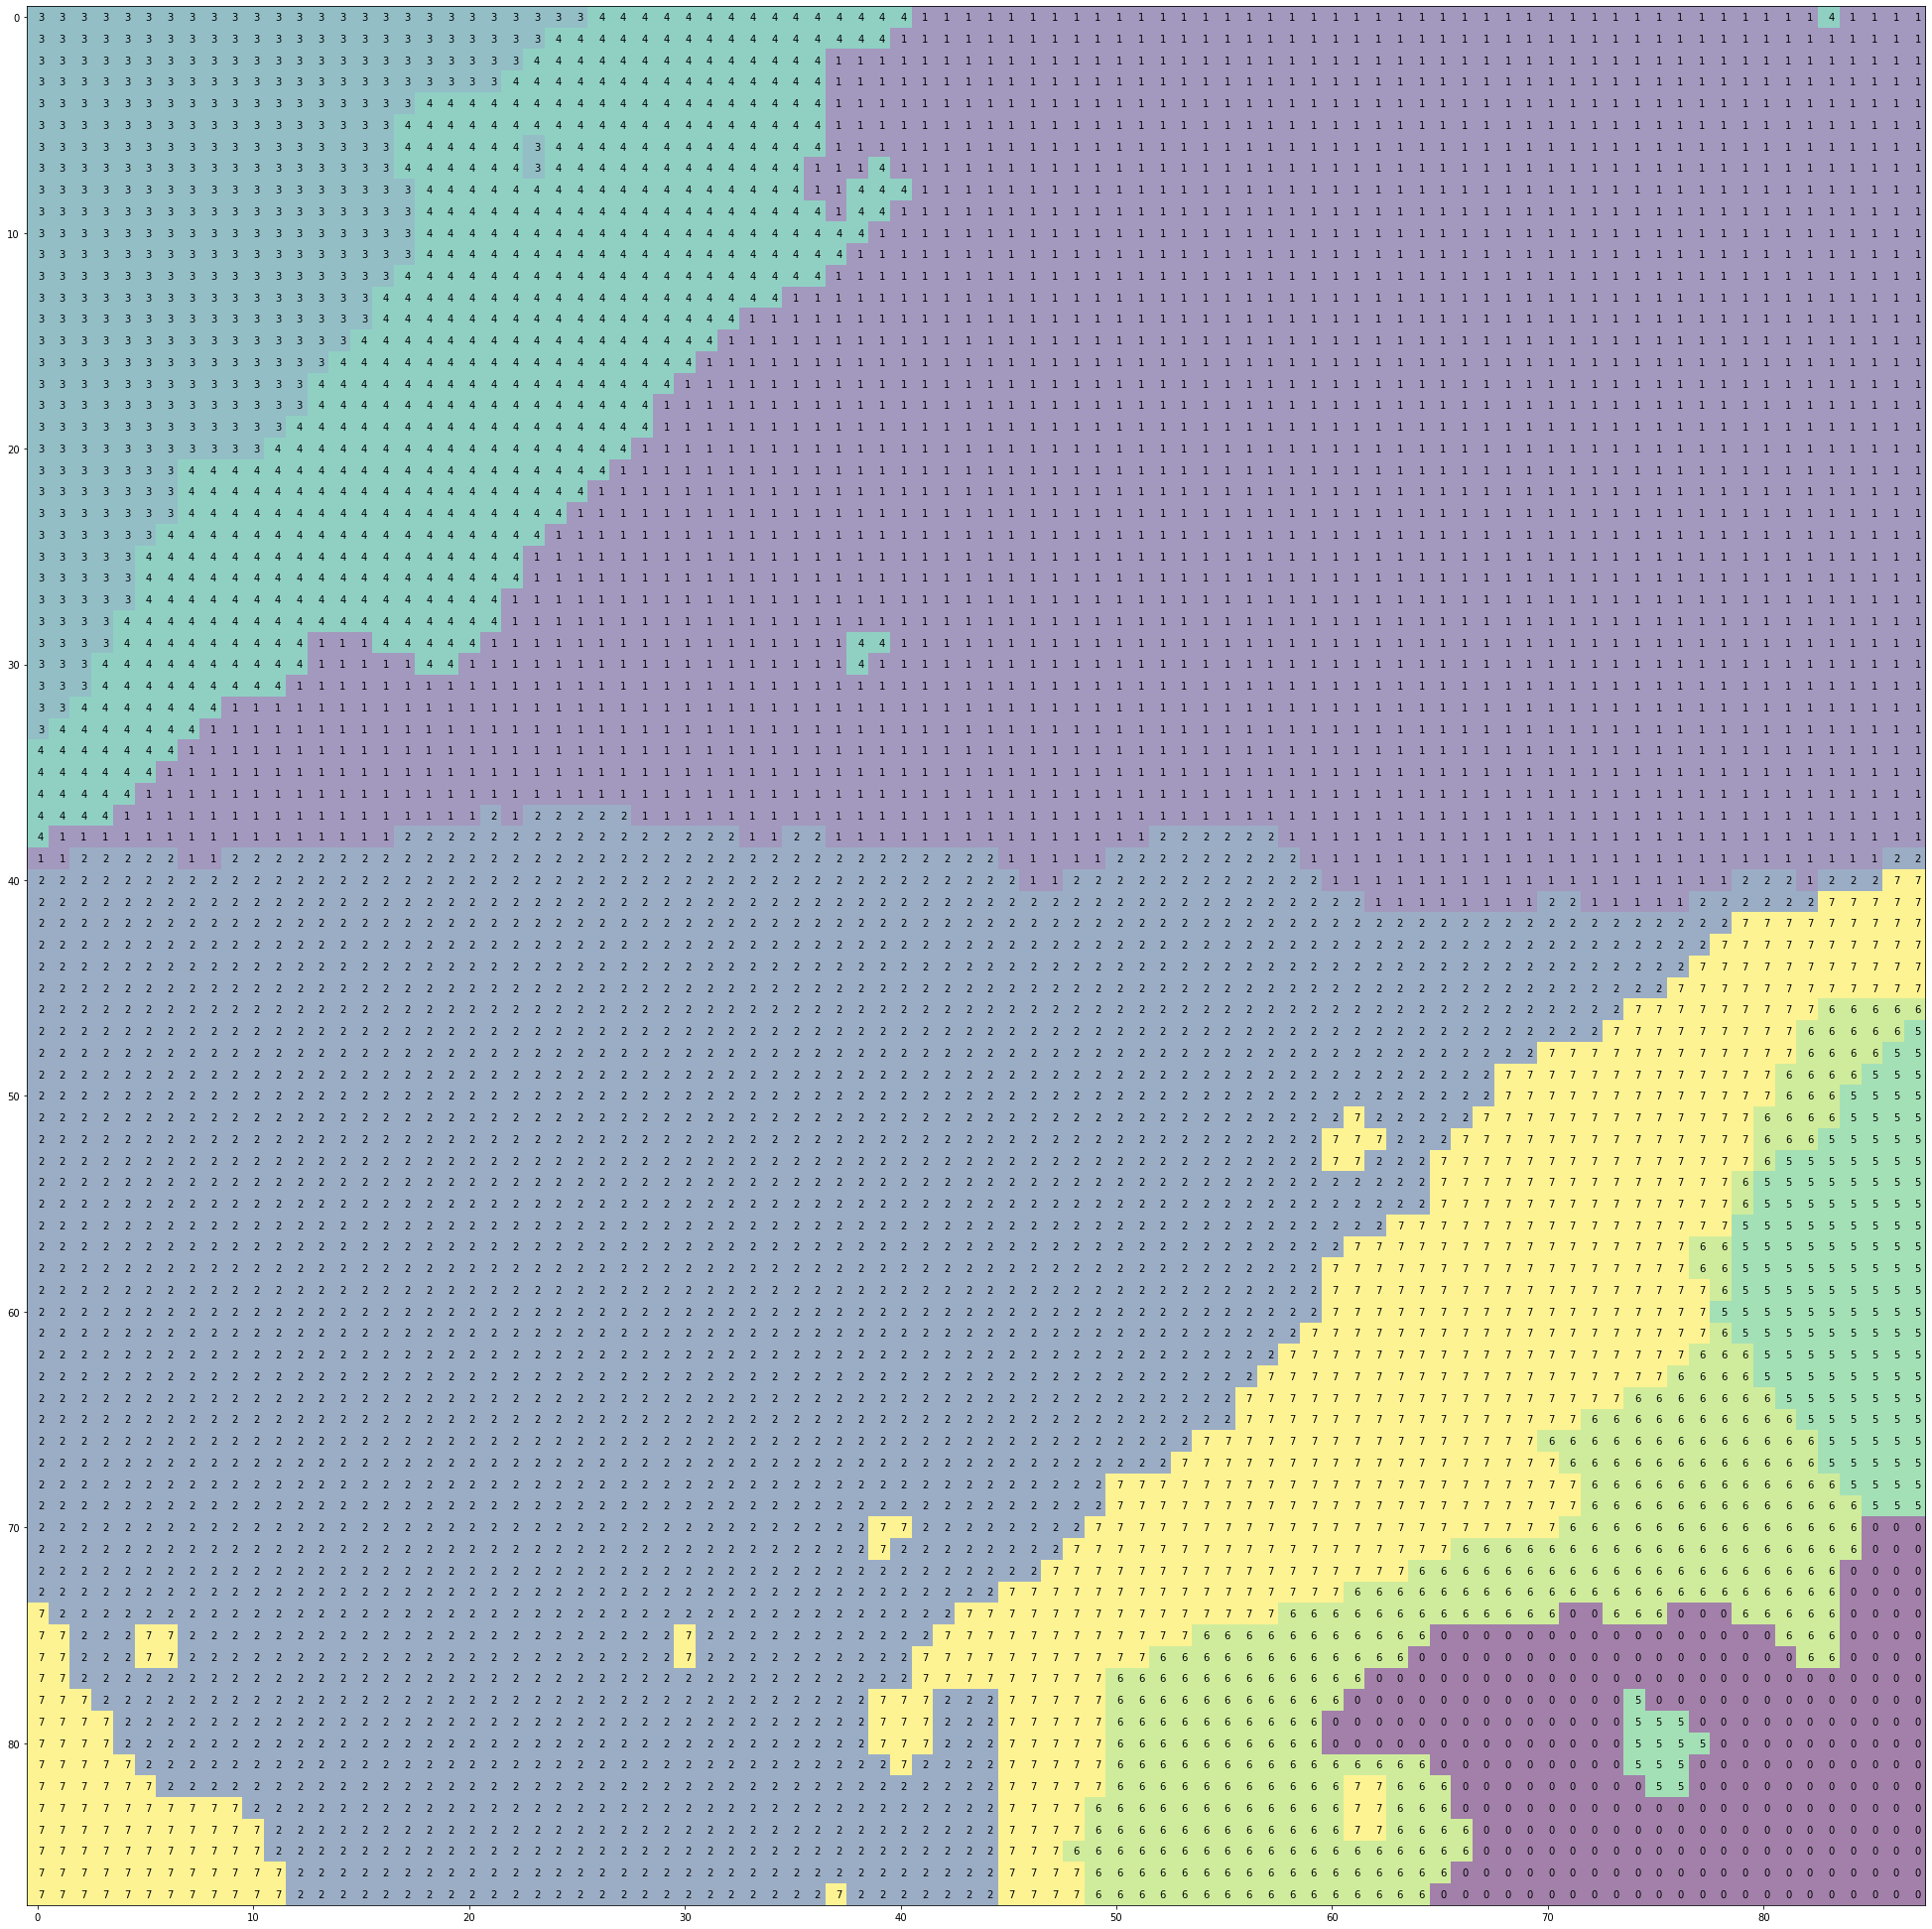

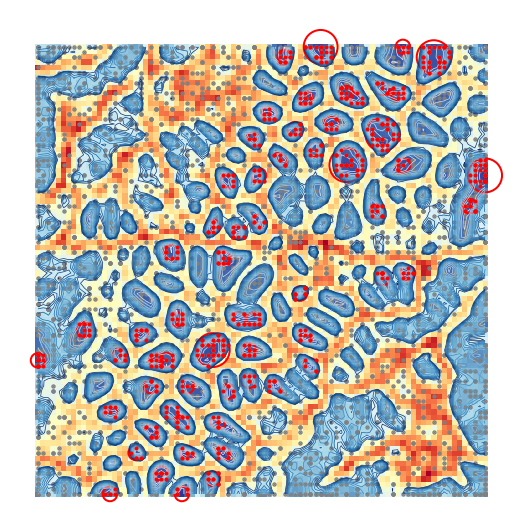

In [14]:
view2D  = sm.hit_map_cluster_number()
view2D  = sm.view_U_matrix()

# Generate and save BMU's

In [15]:
bmus = []
# print(np.asarray(data['fingerprints'][0]).shape)
for features in tqdm(data_features_bmu):
    bmu_list = []
    for feature in features:
        # print(feature)
        # feature = np.asarray(feature)
        # print(feature.shape)
        # bmu = sm.project_data(np.asarray(feature).reshape(features_shape[0] * features_shape[1], -1))
        bmu = sm.project_data(np.asarray(feature).reshape(1, -1))

        # print(feature.shape)
        bmu_list.append(bmu.tolist())
    bmus.append(bmu_list)
# data['bmus'] = bmus

# tmp_bmus = [0] * len(data['fingerprints'])
# index = 0
# j = 0
# for fingerprint in data['fingerprints']:
#     tmp_bmus[index] = []
#     for i in range(len(fingerprint)):
#         tmp_bmus[index].append(bmus[j])
#         j += 1
#     index += 1
    
data['bmus'] = bmus

with open(path_chunks, 'wb') as _file:
    pickle.dump(data, _file)

100%|██████████| 602/602 [20:47<00:00,  2.07s/it]


In [16]:
data_to_dict = {}
for key in data.keys():
    tmp = []
    for el in data[key]:
        tmp.append(el)
    data_to_dict[key] = tmp

# Export as JSON

In [17]:
import json

# output_json = data.to_json(orient='columns')
def convert(o):
    '''
        workaround from stackoverflow to prevent error
        when having data from numpy
    '''
    if isinstance(o, np.int64): return int(o)
    if isinstance(o, np.float64): return float(o)
    raise TypeError

data_to_dict = {}
for key in data.keys():
    tmp = []
    for el in data[key]:
        tmp.append(el)
    data_to_dict[key] = tmp

del data_to_dict['Unnamed: 0']
# remove NaNs
index = 0
for d in data_to_dict['Description']:
    if isinstance(d, str) == False:
        data_to_dict['Description'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Mode']:
    if isinstance(d, str) == False:
        data_to_dict['Mode'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Location']:
    if isinstance(d, str) == False:
        data_to_dict['Location'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Modulation']:
    if isinstance(d, str) == False:
        data_to_dict['Modulation'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Frequency']:
    if isinstance(d, str) == False:
        data_to_dict['Frequency'][index] = "NaN"
    index += 1

index = 0
for d in data_to_dict['Bandwidth']:
    if isinstance(d, str) == False:
        data_to_dict['Bandwidth'][index] = "NaN"
    index += 1

parse_to_json = json.dumps(data_to_dict, default=convert)



file_name_base = os.path.splitext(path_chunks)[0]
with open(file_name_base + '_data.json', 'w') as f:
    f.write(parse_to_json)

cb = sm.codebook[:]
codebook = {
    'data': cb.tolist(),
    'size': map_size
}

with open(file_name_base + '_codebook.json', 'w') as _file:
    json.dump(codebook, _file)